In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from Bio import SeqIO
from Bio.SeqIO import SeqRecord
from Bio.Seq import Seq
from matplotlib import pyplot as plt

In [2]:
# Load the GTDB phylogeny.
# Note -- annotree is r89 of GTDB as of 04/27/20
# Unfortunately these files have no header.
gtdb_taxonomy_bac = pd.read_csv('../gtdb/bac120_taxonomy_r89.tsv', sep='\t', header=None)
gtdb_taxonomy_arc = pd.read_csv('../gtdb/ar122_taxonomy_r89.tsv', sep='\t', header=None)
gtdb_taxonomy_bac.columns = ['gtdbId', 'taxonomy']
gtdb_taxonomy_arc.columns = ['gtdbId', 'taxonomy']
gtdb_taxonomy_bac.set_index('gtdbId', inplace=True)
gtdb_taxonomy_arc.set_index('gtdbId', inplace=True)

def add_taxonomic_information(annotree_df):
    """Adds phylogeny in-place, returns ref to same DF"""
    # Lookup the GTDB IDs in the taxonomy files
    t_domain, t_phylum, t_class, t_order, t_family = [], [], [], [], [] 
    t_genus, t_species = [], []
    for idx, row in annotree_df.iterrows():
        gtdb_id = row.gtdbId    
        bac_tax, arc_tax = None, None
        if gtdb_id in gtdb_taxonomy_bac.index:
            bac_tax = gtdb_taxonomy_bac.at[gtdb_id, 'taxonomy']
        if gtdb_id in gtdb_taxonomy_arc.index:
            arc_tax = gtdb_taxonomy_arc.at[gtdb_id, 'taxonomy']

        # Better have taxonomic information or something is up.
        tax = bac_tax or arc_tax
        assert tax is not None

        t_split = [t.split('__')[1] for t in tax.split(';')]
        dom, phy, cla, order, fam, genus, spe = t_split
        t_domain.append(dom)
        t_phylum.append(phy)
        t_class.append(cla)
        t_order.append(order)
        t_family.append(fam)
        t_genus.append(genus)
        t_species.append(spe)
        
    annotree_df['domain'] = t_domain
    annotree_df['phylum'] = t_phylum
    annotree_df['class'] = t_class
    annotree_df['order'] = t_order
    annotree_df['family'] = t_family
    annotree_df['genus'] = t_genus
    annotree_df['species'] = t_species

    # GTDB splits firmicutes and chloroflexi into multiple groups. I'm sure this is right, but will confuse many.
    annotree_df['phylum_'] = [ph.split('_')[0] for ph in annotree_df.phylum]
    return annotree_df

In [3]:
def filter_annotree_df(annotree_df, min_length, max_length):
    """Remove long/short seqs and duplicates."""
    # remove short and long sequences
    mask = annotree_df.sequence.str.len() > min_length
    mask &= annotree_df.sequence.str.len() < max_length
    filtered_df = annotree_df[mask]
    
    # Keep the first of the duplicate matched because it had a lower E-val
    # (this is how annotree appears to output things)
    dup_cols = ['geneId', 'gtdbId', 'pfamId', 'sequence']
    deduplicated_df = annotree_df.drop_duplicates(subset=dup_cols, keep='first')
    return deduplicated_df

def make_fasta_from_annotree_csv(annotree_df, out_fasta_fname):
    """Convert to FASTA."""
    seqrecords = []
    # Collect records with GTDB gene ID for reference.
    for idx, row in annotree_df.iterrows():
        seqrecords.append(SeqRecord(Seq(row.sequence), id=row.geneId))
        
    # Write FASTA
    with open(out_fasta_fname, 'w') as outf:
        SeqIO.write(seqrecords, outf, 'fasta')

In [4]:
# Read both rubisco and malate synthase files
rubisco_fname = '../annotree_data/PF00016_rubisco_large_042720.csv'
rubisco_df = pd.read_csv(rubisco_fname)
rubisco_df = add_taxonomic_information(rubisco_df)
rubisco_df.to_csv('../annotree_data/PF00016_rubisco_large_042720_phylo.csv')
rub_lens = rubisco_df.sequence.str.len()

ms_fname = '../annotree_data/PF01274_malate_synthase_042720.csv'
ms_df = pd.read_csv(ms_fname)
ms_df = add_taxonomic_information(ms_df)
ms_df.to_csv('../annotree_data/PF01274_malate_synthase_042720_phylo.csv')
ms_lens = ms_df.sequence.str.len()

icl_fname = '../annotree_data/PF00463_isocitrate_lyase_070920.csv'
icl_df = pd.read_csv(icl_fname)
icl_df = add_taxonomic_information(icl_df)
icl_df.to_csv('../annotree_data/PF00463_isocitrate_lyase_070920_phylo.csv')
icl_lens = icl_df.sequence.str.len()

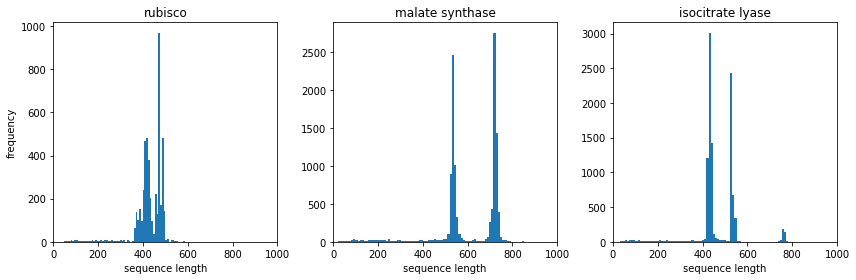

In [5]:
# Plot sequence length distributions to figure out what the right thresholds are.
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
ax0 = axs[0]
ax0.hist(rub_lens[rub_lens < 1000], bins=100)
ax0.set_xlim(0, 1000)
ax0.set_title('rubisco')
ax0.set_xlabel('sequence length')
ax0.set_ylabel('frequency')

ax1 = axs[1]
ax1.hist(ms_lens[ms_lens < 1000], bins=100)
ax1.set_xlim(0, 1000)
ax1.set_title('malate synthase')
ax1.set_xlabel('sequence length')

ax2 = axs[2]
ax2.hist(icl_lens[icl_lens < 1000], bins=100)
ax2.set_xlim(0, 1000)
ax2.set_title('isocitrate lyase')
ax2.set_xlabel('sequence length')

plt.tight_layout()
plt.show()

In [6]:
# Loose filters since we are just trying to get rid of absurd cases here.
rub_filtered_df = filter_annotree_df(rubisco_df, min_length=200, max_length=800)
ms_filtered_df = filter_annotree_df(ms_df, min_length=200, max_length=900)
icl_filtered_df = filter_annotree_df(icl_df, min_length=200, max_length=900)

In [7]:
print('Rubisco: pre-filtered size: %d; post: %d' % (rubisco_df.index.size, rub_filtered_df.index.size))
print('Malate Synthase: pre-filtered size: %d; post: %d' % (ms_df.index.size, ms_filtered_df.index.size))
print('Isocitrate lyase: pre-filtered size: %d; post: %d' % (icl_df.index.size, icl_filtered_df.index.size))

# Should have no duplicate IDs now that we've filtered. 
# This was achieved by dropping duplicates, but the duplicates were determined by IDs and sequence
# So this check ensures all the duplicate IDs in fact had the same sequence.
assert rub_filtered_df.geneId.unique().size == rub_filtered_df.index.size
assert ms_filtered_df.geneId.unique().size == ms_filtered_df.index.size
assert icl_filtered_df.geneId.unique().size == icl_filtered_df.index.size

# Save the filtered file as CSV
rub_filtered_df.to_csv('../annotree_data/PF00016_rubisco_large_042720_filtered.csv', index=False)
ms_filtered_df.to_csv('../annotree_data/PF01274_malate_synthase_042720_filtered.csv', index=False)
icl_filtered_df.to_csv('../annotree_data/PF00463_isocitrate_lyase_070920_filtered.csv', index=False)

# Make a fasta file of the filtered rubiscos for usearch
make_fasta_from_annotree_csv(rub_filtered_df, '../annotree_data/PF00016_rubisco_large_042720_filtered.fa')

Rubisco: pre-filtered size: 4831; post: 4644
Malate Synthase: pre-filtered size: 11608; post: 11596
Isocitrate lyase: pre-filtered size: 10424; post: 8727


In [8]:
# Make a sequence database for type IV rubiscos for usearch 
jaffee_seqs = SeqIO.parse('../rubisco_sequences/jaffe_et_al_2018_rubisco_superfamilies.faa', 'fasta')
typeIVs = []
for sr in jaffee_seqs:
    rub_id = sr.id
    rub_type = rub_id.split(':')[-1]
    
    if rub_type == 'IV':
        typeIVs.append(sr)
        
with open('../rubisco_sequences/example_fIVs.fasta', 'w') as outf:
    SeqIO.write(typeIVs, outf, 'fasta')
    
!mkdir -p usearch
!usearch -makeudb_usearch ../rubisco_sequences/example_fIVs.fasta -output ../usearch/example_fIVs.udb

/bin/bash: usearch: command not found


In [9]:
# Search against the usearch database, retaining only those sequences that are not within 30% ID of a form IV.
!usearch -usearch_global ../annotree_data/PF00016_rubisco_large_042720_filtered.fa -db ../usearch/example_fIVs.udb -id 0.35 -notmatched ../usearch/rubs_not_fIV.fa

/bin/bash: usearch: command not found


In [10]:
retained_rub_gene_ids = []
usearch_non_match_fname = '../usearch/rubs_not_fIV.fa'
for sr in SeqIO.parse(usearch_non_match_fname, 'fasta'):
    retained_rub_gene_ids.append(sr.id)
    
n_retained = len(retained_rub_gene_ids)
print('Rubisco: %d of %d did not match any fIV query' % (n_retained, rub_filtered_df.index.size))
print('These are presumed to be carboxylases')

# Retained genes are likely carboxylases
carboxylase_df = rub_filtered_df[rub_filtered_df.geneId.isin(retained_rub_gene_ids)]
carboxylase_df.to_csv('../annotree_data/PF00016_rubisco_large_042720_not_fIV.csv', index=False)

Rubisco: 2856 of 4644 did not match any fIV query
These are presumed to be carboxylases
